<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw15/Homework/hw15/Homework15_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install denoising_diffusion_pytorch

# Imports

In [2]:
import copy

import numpy as np

import torch
from torch import nn
import torch.distributions as D
from torch import autograd

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from denoising_diffusion_pytorch import Unet

import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [3]:
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16)),
    transforms.Normalize((0.5), (0.5)),
])

In [6]:
train_data = MNIST(root='./data/', train=True, download=True, transform=transform)
val_data = MNIST(root='./data/', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
BATCH_SIZE = 128

In [8]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

# Utils

In [9]:
def f_(f, x):
    x = x.clone()
    
    with torch.enable_grad():
        if not x.requires_grad:
            x.requires_grad = True

        y = f(x)
        
        (grad, ) = autograd.grad(y.sum(), x, create_graph=False)
        
    return grad

In [44]:
@torch.no_grad()
def solve_sde(x, f, g, ts=0, tf=1, dt=1e-3):
    for t in tqdm(np.arange(ts, tf, dt)):
        tt = torch.FloatTensor([t]).to(device) # .repeat(x.shape[0])
        z = torch.randn_like(x).to(device)
        x = x + f(x, tt) * dt + g(tt) * z * abs(dt) ** 0.5
        
    return x

In [34]:
@torch.no_grad()
def show_imgs(x):
    x = x.detach().cpu()
    
    img = make_grid(x, nrow=5)
    img = img.permute(1, 2, 0)
    img = img * 0.5 + 0.5

    plt.imshow(img.numpy())
    plt.show()

# Question 1. DDPM

В этом задание вам предлагается реализовать диффузную модель с непрерывным временем на основе DDPM. Технический код уже написан, нужно лишь восстановить содержательные функции.

In [12]:
class ContDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps_th = Unet(
            dim=16,
            dim_mults=(1, 2, 3),
            channels=1
        )
        
    def device(self):
        return next(self.parameters()).device
        
    def gamma(self, t):
        return torch.log(torch.expm1(1e-4 + 10 * t ** 2))
    
    # Coefficient \bar{a}_t
    # see presentation, slide 19
    def a_bar(self, t):
        g = self.gamma(t)
        return torch.sigmoid(-g)
    
    def sigma_2(self, t):
        return 1 - self.a_bar(t)
    
    def log_a_bar_sqrt_(self, t):
        return 0.5 * f_(lambda s: torch.log(self.a_bar(s)), t)
    
    # Coefficient f(x, t)
    # see presentation, slide 31
    def f(self, x_t, t):
        return self.log_a_bar_sqrt_(t) * x_t
    
    # Coefficient g^2(t)
    # see presentation, slide 31
    def g_2(self, t):
        return f_(self.sigma_2, t) - 2 * self.log_a_bar_sqrt_(t) * self.sigma_2(t)
    
    # Learned score function
    # see presentation, slide 28
    def score(self, x_t, t):
        """
        x_t: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - score: tensor  [bs, 1, 16, 16]
        """
        # TODO
        eps = self.eps_th(x_t, t)
        sigma = self.sigma_2(t).sqrt().reshape(-1, 1, 1, 1)

        return - eps / sigma
    
    def sample_t(self, bs):
        device = self.device()
        t = torch.rand(bs).to(device)
        return t
        
    # Transition sampling q(x_t|x_0)
    # see presentation, slide 19 and 25
    def sample_x_t(self, x_0, t):
        """
        x_0: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - x_t: tensor  [bs, 1, 16, 16]
        """
        # TODO
        eps = torch.randn_like(x_0)

        a_bar = self.a_bar(t)

        mu = torch.sqrt(a_bar).reshape(-1, 1, 1, 1) * x_0
        sigma = torch.sqrt(1 - a_bar).reshape(-1, 1, 1, 1)

        sample = mu + sigma * eps

        return sample, eps

    # Loss function
    # see presentation, slide 26
    def get_loss(self, x_0):
        device = self.device()
        bs = x_0.shape[0]
        data_dims = tuple(np.arange(1, len(x_0.shape)))
        
        t = self.sample_t(bs)
        x_t, eps = self.sample_x_t(x_0, t)
        
        loss = ((eps - self.eps_th(x_t, t)) ** 2).sum(dim=data_dims)
        loss = loss.mean()
        
        return loss
        
    # Sampling according to reverse SDE
    # see presentation, slide 32
    # Hint: use solve_sde function
    def sample_sde(self, bs):
        """
        bs: int

        Returns
        - x_0: tensor  [bs, 1, 16, 16] generated data
        """
        # TODO
        x_t = torch.randn(bs, 1, 16, 16, device=self.device())

        # очень долго над этим думал, жесть 
        f = lambda x, t: self.f(x, t) - self.g_2(t) * self.score(x, t)
        g = lambda t: self.g_2(t).sqrt()

        x_0 = solve_sde(x_t, f=f, g=g) 

        return x_0      

## Training

In [13]:
def calc_losses(ddpm, x):
    loss = ddpm.get_loss(x)

    return loss

In [14]:
def train_step(ddpm, x, optim):
    loss_total = calc_losses(ddpm, x)
    
    optim.zero_grad()
    loss_total.backward()
    optim.step()
    
    return loss_total.item()

In [15]:
def train_epoch(ddpm, data_loader, optim):
    ddpm.train()

    losses = []
    for x, _ in tqdm(data_loader, "Epoch", leave=False):
        x = x.to(device)

        loss_total = train_step(ddpm, x, optim)
        
        losses += [loss_total]
        
    loss_mean = np.mean(losses)

    return loss_mean

In [16]:
@torch.no_grad()
def val_epoch(ddpm, data_loader):
    ddpm.eval()

    losses = []
    for x, _ in tqdm(data_loader, "Eval", leave=False):
        x = x.to(device)

        total_loss = calc_losses(ddpm, x).item()
        
        losses += [total_loss]
        
    loss_mean = np.mean(losses)

    return loss_mean

In [17]:
def train(ddpm, train_loader, val_loader, optim, epochs):
    for epoch in trange(epochs):
        train_los = train_epoch(ddpm, train_loader, optim)
        # вот это пранк
        # val_los = train_epoch(ddpm, train_loader, optim)
        val_los = val_epoch(ddpm, val_loader)
        tqdm.write(f"train: {train_los}    val: {val_los}")

## Experiment

In [42]:
ddpm = ContDDPM()
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=1e-3)

train(ddpm, train_loader, val_loader, optim, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/468 [00:00<?, ?it/s]

Eval:   0%|          | 0/78 [00:00<?, ?it/s]

train: 31.917817301220364    val: 16.477894257276485


Epoch:   0%|          | 0/468 [00:00<?, ?it/s]

Eval:   0%|          | 0/78 [00:00<?, ?it/s]

train: 16.25017535380828    val: 13.963196302071596


Epoch:   0%|          | 0/468 [00:00<?, ?it/s]

Eval:   0%|          | 0/78 [00:00<?, ?it/s]

train: 13.91177302140456    val: 13.381094908102964


Epoch:   0%|          | 0/468 [00:00<?, ?it/s]

Eval:   0%|          | 0/78 [00:00<?, ?it/s]

train: 13.070361233165121    val: 12.707799067864052


Epoch:   0%|          | 0/468 [00:00<?, ?it/s]

Eval:   0%|          | 0/78 [00:00<?, ?it/s]

train: 12.668869976304535    val: 12.656605732746613


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


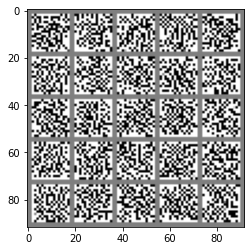

In [46]:
x = ddpm.sample_sde(bs=25) 
show_imgs(x)

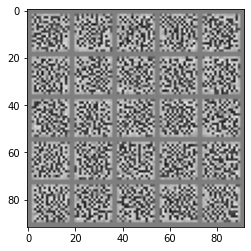

In [47]:
show_imgs(2 * ((x - x.min()) / (x.max() - x.min())) - 1)
# чет хз

# Bonus. Conditional generation

На паре мы обсуждали возможность делать условную генерацию с помощью диффузных моделей (см. презентацию, слайд 35). Бонусное задание - реализовать генерацию с условием на класс. Для этого нужно:

*   Обучить безусловную генерацию из первого задания
*   Обучить классификатор обусловленный на время
*   Собрать все вместе

